# Nonequilibrium free-energy calculation of solids using LAMMPS

This notebook demonstrates the application of nonequilibrium techniques for the calculation of free energies of solids using molecular dynamics (MD) simulations. The methods implemented here are based on **Frenkel-Ladd**, and **Reversible-scaling** thermodynamic paths. 

Calculations presented here are based on https://github.com/jan-janssen/pyiron-free-energy where classes for Frenkel-Ladd and Reversible Scaling are developed and tested within the pyiron package.

The main work intriduced here is based on reproducing the results of https://DOI.org/10.1016/j.commatsci.2015.10.050.

In [1]:
from pyiron import Project
import numpy as np
import scipy as sci
import pandas
from jinja2 import Template
import matplotlib.pyplot as plt 
import scipy.constants as sc
from scipy.integrate import cumtrapz
import os

## Sumary for the theoretical background

Jarzynski’s equality then connects this distribution to the free-energy difference $\Delta F$ between the equilibrium states defined by the parameters at the two ends of
the path through:

$$\exp(-\beta \Delta F) = \overline{\exp(-\beta W_{irr})}$$

Another way to avoid the statistical uncertainities is done as,

$$\Delta F = W_{irr} = \overline{W_{irr}} - \overline{E_{diss}}$$

Then, for a linear-response nonequilibrium process connecting states 1 and 2, we have $E^{diss}_{1\rightarrow2} = E^{diss}_{2\rightarrow1}$, then we can write,


\begin{equation}
\begin{aligned}
\Delta F &\equiv F_{2} - F_{1} \\
&\equiv \frac{1}{2} (W^{rev}_{1\rightarrow 2} - W^{rev}_{2\rightarrow 1}) \\
&= \frac{1}{2} (\overline{W^{irr}_{1 \rightarrow 2}} - \overline{W^{irr}_{2 \rightarrow 1}})
\end{aligned}
\end{equation}

The standard way of thermodynamic integration to calculate the free energy is done as,

\begin{equation}
\begin{aligned}
\Delta F &= F(\lambda_{f}) - F(\lambda_{i}) = \int_{\lambda_{i}}^{\lambda_{f}} d\lambda \langle \frac{\partial H}{\partial \lambda}\rangle_{\lambda}\\
&\equiv W^{rev}_{i \rightarrow f}
\end{aligned}
\end{equation}

When we deal with nonequilibrium process, we introduce the switching time. So, the integeral is estimated in terms of the irriversible work where $\lambda = \lambda (t)$ is explicitly time-dependent and varies from $\lambda_{i}$ to $\lambda_{f}$ in a switching time $t_{s}$. Then, the integeral is written as,

$$W^{irr}_{i \rightarrow f} = \int^{t_{s}} dt \frac{d\lambda}{dt} (\frac{\partial H}{\partial \lambda})_{\Gamma(t)}$$

$\Gamma(t)$ represents the phase space trajectory of the system along the process. The integeral can be performed numerically in the following form,

$$\boxed{W^{irr}_{i \rightarrow f} = \sum_{k=0}^{N-1} \Delta \lambda(k)(\frac{\partial H}{\partial \lambda})_{\Gamma(k\Delta t)}}$$ 

The application of the mentioned theoretical background is applied in two specific thermodynamic paths, named **Frenkel-Ladd**, and **Reversible scaling** paths. 

In [2]:
pr = Project("reproduce_results")
pr.remove_jobs_silently(recursive=True)
pr.removedirs()

In [3]:
fl_input = open('fl_input','r')
fl_input = fl_input.read()
print(fl_input)

# This script runs a Frenkel-Ladd thermodynamic integration for the calculation of the free energy of bcc iron. See job.sh for the variables that need to be passed in the command line.


#--------------------------- Simulation variables -----------------------------#
  # Initalizes the random number generator.
  variable         rnd equal round(random(0,999,{{ RANDOM }}))

  # Simulation control parameters.
  variable         t_eq equal {{  t_eq  }}          # Equilibration timesteps.
  variable         t_switch equal {{  t_switch  }}  # Switching timesteps.
  variable         t_step equal {{  t_step  }}      # Timestep.
  variable         T equal {{  temp  }}             # Simulation temprerature.
#------------------------------------------------------------------------------#


#---------------------------- Atomic setup ------------------------------------#
  units            metal

  # Create atoms.
  read_data        structure.inp

  # Define interatomic potential.
  include       

In [4]:
rs_input = open('rs_input','r')
rs_input = rs_input.read()
print(rs_input)

# This script runs a Reversible Scaling thermodynamic integration for the calculation of the temperature dependence of the free energy of bcc iron. See job.sh for the variables that need to be passed in the command line.


#--------------------------- Simulation variables -----------------------------#
  # Initalizes the random number generator.
  variable         rnd equal round(random(0,999,{{ RANDOM }}))

  # Simulation control parameters.
  variable         t_eq equal {{ t_eq }}            # Equilibration timesteps.
  variable         t_switch equal {{ t_switch }}    # Switching timesteps.
  variable         t_step equal {{ t_step }}        # Timestep.
  variable         T equal {{temp}}                 # Simulation temperature.
#------------------------------------------------------------------------------#


#---------------------------- Atomic setup ------------------------------------#
  units            metal

  # Create atoms.
  read_data        structure.inp

  # Define Inte

## Frenkel Ladd Path

The parametrical form of the Hamiltonian is written in the form,

$$ H(\lambda) = \lambda H_{f} + (1-\lambda)H_{i}$$

The corresponding forward irreversible work estimator is dettermined as,

$$ W^{irr}_{i \rightarrow f} = \int_{0}^{t_{s}} dt \frac{d\lambda}{dt}\big[H_{f}(\Gamma(t)) - H_{i}(\Gamma(t))\big] $$

The initial Hamiltonian is chosen to be that of the system of interest for which we wish to compute free energy, it takes the form as,

$$ H_{i} \equiv H_{0} = \sum_{i=1}^{N} \frac{\textbf{P}^{2}}{2m} + U(\textbf{r})$$

The other Hamiltonian is assumed to be that of a system with non-interacting particles, known as Einstein crystal, written as,

$$ H_{f} \equiv H_{E} = \sum_{i=1}^{N} \bigg[\frac{\textbf{P}_{i}^{2}}{2m} + \frac{1}{2}m\omega^{2}(\textbf{r}_{i} - \textbf{r}_{i}^{0})^{2}\bigg] $$

where $\omega$ is the oscilator frequency, and $r_{i}^{0}$ is the equilibrium position of particle $i$ in system $H_{0}$, the Helmholtz free energy is written as,

$$F_{E}(N,V,T) = 3Nk_{B}T ln\bigg(\frac{\hbar \omega}{k_{B}T}\bigg)$$

Then, the free energy of interets can be estimated in terms of the irreversible work of the two states (i.e. $W^{irr}_{i \rightarrow f}$, and $W^{irr}_{f \rightarrow i}$.) as,

$$ F_{0}(N,V,T) = F_{E}(N,V,T) + \frac{1}{2}\big(\overline{W^{irr}_{i \rightarrow f}} - W^{irr}_{i \rightarrow f}\big) $$

### Class for the implementation of Frenkel-Ladd path

In [5]:
class FrenkelLadd:
    def __init__(self, pr=None, potential=None, element=None, phase=None, struct_size=None, alat=None, temperature_lst=None,
                 latts_lst=None, k_lst=None, fl_input=None, params=None, restart=False):
        self.pr = pr
        self.job_fl = None
        self.restart = restart
        self.potential = potential
        self.element = element
        self.phase = phase
        self.struct_size = struct_size
        self.alat = alat 
        self.structure = None
        self.temperature_lst = temperature_lst
        self.latts_lst = latts_lst
        self.k_lst = k_lst
        self.fl_input = fl_input
        self.T = np.array(temperature_lst)
        self.k = np.array(k_lst)
        self.m = None
        self.natoms = None
        self.I_forw = list()
        self.I_back = list()
        self.T_fl = None
        self.F_fl = None
        self.t_eq = params[0]
        self.t_switch = params[1]
        self.t_step = params[2]

    def parameterize(self):
        kB = sc.value('Boltzmann constant in eV/K')
        self.latts_lst = np.zeros(len(self.temperature_lst))
        self.k_lst = np.zeros(len(self.temperature_lst))
        for i, temp in enumerate(self.temperature_lst):
            job = self.pr.create_job('Lammps',f'fl_parameterize_relax_{self.phase}_T_{int(temp)}', True)
            job.structure = self.pr.create_ase_bulk(self.element, self.phase, a=self.alat, cubic=True).repeat(self.struct_size)
            job.potential = self.potential
            job.calc_md(pressure=0, temperature=temp, langevin=True)
            job.run()
            self.latts_lst[i] = job.get_structure().cell[0,0]/self.struct_size
            self.k_lst[i] = 3*kB*temp/np.average(sci.linalg.norm(job.output.total_displacements[-1,:,:], axis=-1)**2)
        
    def run_jobs(self):
        self.a = np.array(self.latts_lst)
        self.k = np.array(self.k_lst)
        for temp, alat, k in zip(self.temperature_lst, self.latts_lst, self.k_lst):
            job_fl = self.pr.create_job(pr.job_type.Lammps, f"lmp_frenkel_ladd_{self.phase}_T_{int(temp)}" , self.restart)
            job_fl.structure = self.pr.create_ase_bulk(self.element, self.phase, a=alat, cubic=True).repeat(self.struct_size)
            self.structure = job_fl.structure
            job_fl.potential = self.potential
            tm_frenkel_ladd = Template(self.fl_input)
            job_fl.input.control.load_string(
                tm_frenkel_ladd.render(
                    RANDOM=np.random.randint(999),
                    t_eq=self.t_eq,             # Equilibration timesteps.
                    t_switch=self.t_switch,     # Switching timesteps
                    t_step=self.t_step,         # Timestep
                    temp=temp,                  # Simulation temperature
                    k=k                         # Spring constant
                )
            )
            job_fl.run()
            job_fl.decompress()
            
            dE, lamb = np.loadtxt(os.path.join(job_fl.working_directory, "forward.dat"), unpack=True)
            self.I_forw.append(np.trapz(dE,lamb))
            dE, lamb = np.loadtxt(os.path.join(job_fl.working_directory, "backward.dat"), unpack=True)
            self.I_back.append(np.trapz(dE,lamb))
            
    def compute_free_energy(self):
        kB = sc.value('Boltzmann constant in eV/K')
        eV = sc.value('electron volt')
        hbar = sc.value('Planck constant over 2 pi in eV s')
        mu = sc.value('atomic mass constant')
        
        W = np.zeros(len(self.T)) # Reversible work for each temperature.
        for i in range(len(self.T)):
            W[i] = (self.I_forw[i]-self.I_back[i]) / 2
        
        # Define harmonic reference system free energy [Eq.(15) in the paper].
        species = self.structure.species[0]
        self.m = species.AtomicMass
        self.natoms = len(self.structure)
        omega = np.sqrt(self.k*eV/(self.m*mu)) * 1.0e+10 # [1/s].
        F_harm = 3*self.natoms*kB*self.T * np.log(hbar*omega/(kB*self.T)) # [eV].
        
        # Fixed center of mass correction [Eq.(24) in the paper].
        V = (self.a**3/2) * self.natoms # Total volume.
        F_CM = (kB*self.T)*np.log((self.natoms/V) * (2*np.pi*kB*self.T /
                                                     (self.natoms*self.m*omega**2))**(3/2)) # [eV].
        
        # Compute absolute free energy per atom [Eq.(16) in the paper] and save data.
        self.F_fl = (F_harm + W + F_CM) / self.natoms # [eV/atom].
        self.T_fl = self.T.copy()

    def plot_results(self):
        c = ['#E41A1C','#377EB8','#4DAF4A','#984EA3','#FF7F00','#FFFF33','#A65628','#F781BF','#999999']
        fig = plt.figure()
        ax = fig.add_axes([0.15,0.15,0.80,0.80])

        # Plot.
        ax.plot(self.T_fl[1:], self.F_fl[1:], 'go', label='Frenkel-Ladd')
        ax.plot(self.T_fl[0], self.F_fl[0],'ro', label='$\mathrm{G(T_{0})}$')

        # Add details and save figure.
        ax.set_xlabel(r'Temperature [K]')
        ax.set_ylabel(r'Free energy [eV/atom]')
        ax.legend(loc=1, frameon=False)

## Reversible Scaling Path

The **Reversible Scaling** path is a specific form of the system Hamiltonian $H(\lambda)$ where each value of $\lambda$ corresponds to a specific temperature, thus one can calculate the free energy $F_{0}(N,V,T)$ from a single constant temperature simulation. 

By considering an initial Hamiltonian for the system of interets as,

$$ H_{i} \equiv H_{0} = \sum_{i=1}^{N} \frac{\textbf{P}_{i}^{2}}{2m} + U(\textbf{r}) $$

The free energy in this case is given as,

$$ F_{0}(T_{0}) = -k_{B}TlnQ(T_{0}) + 3Nk_{B}T_{0}ln\Lambda(T{0}) $$

where $\Lambda(T_{0}) = (h^{2}/2\pi mk_{B}T_{0})^{1/2}$ is the thermal de Broglie wavelength, and $Q(T_{0}) = \int d^{3N}\textbf(r)exp[-U(\text{r})/k_{B}T_{0}]$ is the configurational part of the partition function. 

The paramtrical form of the Hamiltonian is then described by a scaling factor $\lambda$ in the potential energy as,

$$ H(\lambda) = \sum_{i=1}^{N} \frac{\textbf{P}_{i}^{2}}{2m} + \lambda U(\textbf{r}) $$

The configurational part of the partition function of the system described by $H(\lambda)$ is,

$$ \int d^{3N}\textbf{r} exp[-\lambda U(\textbf{r})/k_{B}T_{0}] \equiv Q(T_{0}/\lambda) $$

The free energy of these two systems are related, and one can write the free energy as,

$$ F_{0}(T) = \frac{1}{\lambda}F_{T_{0};\lambda} + \frac{3}{2}Nk_{B}T_{0}\frac{ln\lambda}{\lambda} $$

where $T \equiv \frac{T_{0}}{\lambda}$, and $F(T_{0};\lambda)$ is the free energy of the system $H(\lambda)$ for a specific value of the parameter $\lambda$. The irreversible work done can be calculated by applying the nonequilibrium technique as,

$$W^{irr}_{1\rightarrow \lambda_{f}} = \int^{t_{s}}dt \frac{d\lambda}{dt}U(\Gamma(t))$$

The temperature dependence of the free energy described by the system $H_{0}$ is written as,

$$ F_{0}(T) = \frac{F_{0}(T_{0})}{\lambda} + \frac{3}{2}Nk_{B}T_{0}\frac{ln\lambda}{\lambda} + \frac{1}{2\lambda} \big[W^{irr}_{1\rightarrow \lambda} - W^{irr}_{\lambda \rightarrow 1}\big]$$

### Class for the implementation of Reversible Scaling path

In [6]:
class ReversibleScaling:
    def __init__(self, pr= None, potential=None, element=None, phase=None, struct_size=None, params=None, rs_input=None, fl_obj=None, restart=False):
        self.pr = pr
        self.job_rs = None
        self.restart = restart
        self.potential = potential
        self.element = element
        self.phase = phase
        self.struct_size = struct_size
        self.structure = None
        self.fl_obj = fl_obj
        self.alat = fl_obj.latts_lst[0]
        self.rs_input = rs_input
        self.T_rs = None
        self.F_rs = None
        self.T = fl_obj.T
        self.t_eq = params[0]
        self.t_switch = params[1]
        self.t_step = params[2]
        self.temp = params[3]
        self.T_max = params[4]
        
    def run_job(self):
        self.job_rs = self.pr.create_job(self.pr.job_type.Lammps, f"lmp_rs_{self.phase}_{int(self.temp)}", self.restart)
        self.structure = self.pr.create_ase_bulk(self.element,self.phase,a=self.alat,cubic=True).repeat(self.struct_size)
        self.job_rs.structure = self.structure
        self.job_rs.potential = self.potential
        tm_reversible_scaling = Template(self.rs_input)
        pair_style = self.potential['Config'].values[0][0].split()[1]
        self.job_rs.input.control.load_string(
            tm_reversible_scaling.render(
                RANDOM=np.random.randint(999),
                pair_style=pair_style,
                t_eq=self.t_eq,           # Equilibration time: check e.g. double
                t_switch=self.t_switch,   # Switching time: check e.g. double
                t_step=self.t_step,       # Time step: check e.g. reduce 1/2
                temp=self.temp,           # Simulation temperature: check e.g. reduce 1/2
                T_max=self.T_max          # Maximum temperature:  
                
            )
        )
        self.job_rs.run()
        self.job_rs.decompress()
            
    def compute_free_energy(self):
        T0 = self.temp # Reference temperature [K]
        kB = sc.value('Boltzmann constant in eV/K')
        F0 = self.fl_obj.F_fl[self.T==T0]
        
        U_f, lamb_f = np.loadtxt(os.path.join(self.job_rs.working_directory, "forward.dat"), unpack=True)
        U_b, lamb_b = np.loadtxt(os.path.join(self.job_rs.working_directory, "backward.dat"), unpack=True)
        # Fix adapt also scales the potential energy besides the forces, so we unscale.
        U_f /= lamb_f
        U_b /= lamb_b

        # Compute work done using cummulative integrals [Eq.(21) in the paper].
        I_f = cumtrapz(U_f,lamb_f,initial=0)
        I_b = cumtrapz(U_b[::-1],lamb_b[::-1],initial=0)
        W = (I_f+I_b) / (2*lamb_f)

        # Compute free energy [Eq.(22) in the paper] and save results.
        self.T_rs = T0 / lamb_f
        self.F_rs = F0/lamb_f  + 1.5*kB*self.T_rs*np.log(lamb_f) + W
        
    def plot_results(self):
        c = ['#E41A1C','#377EB8','#4DAF4A','#984EA3','#FF7F00','#FFFF33','#A65628','#F781BF','#999999']
        fig = plt.figure()
        ax = fig.add_axes([0.15,0.15,0.80,0.80])

        # Plot.
        ax.plot(self.T_rs, self.F_rs, c=c[0], lw=1)

        # Add details and save figure.
        ax.set_xlabel(r'Temperature [K]')
        ax.set_ylabel(r'Free energy [eV/atom]')  
        
    def plot_all(self):
        c = ['#E41A1C','#377EB8','#4DAF4A','#984EA3','#FF7F00','#FFFF33','#A65628','#F781BF','#999999']
        fig = plt.figure()
        ax = fig.add_axes([0.15,0.15,0.80,0.80])

        # Plot.
        ax.plot(self.T_rs, self.F_rs, '-', c='k', lw=1, label='Reversible Scaling')
        ax.plot(self.fl_obj.T_fl[1:], self.fl_obj.F_fl[1:], 'go', label='Frenkel-Ladd')
        ax.plot(self.fl_obj.T_fl[0], self.fl_obj.F_fl[0],'ro', label='$\mathrm{G(T_{0})}$')

        # Add details and save figure.
        ax.set_xlabel(r'Temperature [K]')
        ax.set_ylabel(r'G(p=0,T) [eV/atom]')
        ax.legend(loc=1, frameon=False)

## Defining the potential

In [7]:
fe_potential = pandas.DataFrame({
  'Name': ['Fe_Potential'],
  'Filename': [[os.path.abspath("Fe.eam")]],
  'Model': ['Custom'],
  'Species': [['Fe']],
  'Config': [['pair_style eam\n', 
              'pair_coeff * * Fe.eam\n']]
})
fe_potential

,Name,Filename,Model,Species,Config
0,Fe_Potential,[/home/sam/programs/ibrsam_git/FreeEnergyNoneqTI/Fe.eam],Custom,[Fe],"[pair_style eam\n, pair_coeff * * Fe.eam\n]"


## Calulations for Fe$_{BCC}$

The job fl_parameterize_relax_bcc_T_100 was saved and received the ID: 1


/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity steps. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity indices. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity velocities. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Co

The job fl_parameterize_relax_bcc_T_400 was saved and received the ID: 2


/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity indices. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity velocities. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity steps. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/atomistics/job/atomistic.py:866: UserWarning:

The job fl_parameterize_relax_bcc_T_700 was saved and received the ID: 3


/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity indices. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity velocities. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity steps. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/atomistics/job/atomistic.py:866: UserWarning:

The job fl_parameterize_relax_bcc_T_1000 was saved and received the ID: 4


/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity indices. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity velocities. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity steps. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/atomistics/job/atomistic.py:866: UserWarning:

The job fl_parameterize_relax_bcc_T_1300 was saved and received the ID: 5


/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity indices. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity velocities. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity steps. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/atomistics/job/atomistic.py:866: UserWarning:

The job fl_parameterize_relax_bcc_T_1600 was saved and received the ID: 6


/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity indices. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity velocities. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity steps. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/atomistics/job/atomistic.py:866: UserWarning:

The job lmp_frenkel_ladd_bcc_T_100 was saved and received the ID: 7


/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/base.py:1014: UserWarning: LAMMPS warning: No dump.out output file found.
  warnings.warn("LAMMPS warning: No dump.out output file found.")
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/base.py:591: UserWarning: LAMMPS warning: log.lammps does not contain the required pressure values.
  warnings.warn("LAMMPS warning: log.lammps does not contain the required pressure values.")


The job lmp_frenkel_ladd_bcc_T_400 was saved and received the ID: 8
The job lmp_frenkel_ladd_bcc_T_700 was saved and received the ID: 9
The job lmp_frenkel_ladd_bcc_T_1000 was saved and received the ID: 10
The job lmp_frenkel_ladd_bcc_T_1300 was saved and received the ID: 11
The job lmp_frenkel_ladd_bcc_T_1600 was saved and received the ID: 12
The job lmp_rs_bcc_100 was saved and received the ID: 13


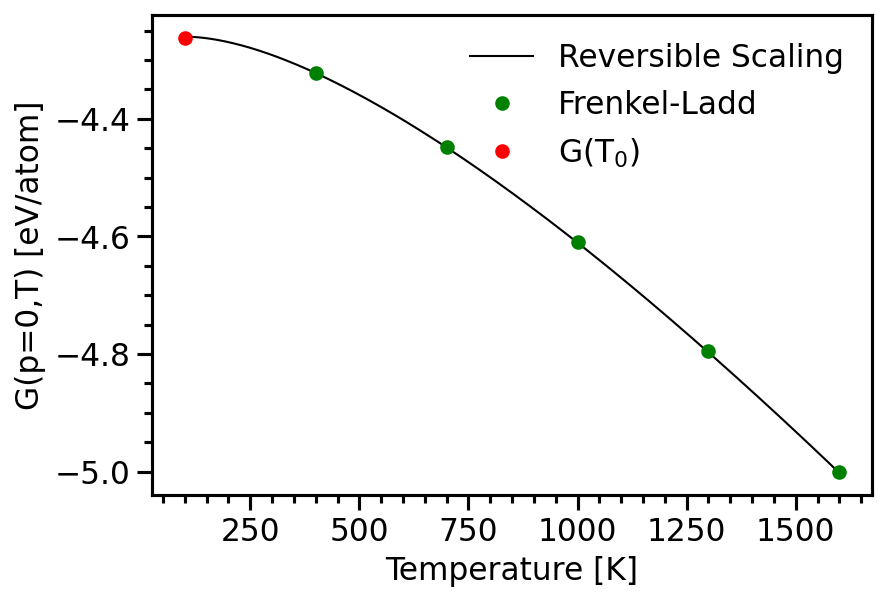

In [8]:
temperature_lst = np.linspace(100, 1600, 6)
fl_params = [1000, 5000, 0.002]

fl_bcc = FrenkelLadd(pr=pr, potential=fe_potential, element='Fe', phase='bcc', struct_size=15, alat=2.88, temperature_lst=temperature_lst,
                     fl_input=fl_input, params=fl_params, restart=True)
fl_bcc.parameterize()
fl_bcc.run_jobs()
fl_bcc.compute_free_energy()
# fl_bcc.plot_results()

rs_params = [1000, 10000, 0.002, 100, 1600]
rs_bcc = ReversibleScaling(pr=pr, potential=fe_potential, params=rs_params, element='Fe', phase='bcc', struct_size=15, rs_input=rs_input,
                           fl_obj=fl_bcc, restart=True)
rs_bcc.run_job()
rs_bcc.compute_free_energy()
rs_bcc.plot_all()

## Calculations for Fe$_{FCC}$

The job fl_parameterize_relax_fcc_T_100 was saved and received the ID: 14


/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity steps. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity indices. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity velocities. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Co

The job fl_parameterize_relax_fcc_T_400 was saved and received the ID: 15


/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity indices. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity velocities. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity steps. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/atomistics/job/atomistic.py:866: UserWarning:

The job fl_parameterize_relax_fcc_T_700 was saved and received the ID: 16


/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity indices. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity velocities. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity steps. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/atomistics/job/atomistic.py:866: UserWarning:

The job fl_parameterize_relax_fcc_T_1000 was saved and received the ID: 17


/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity indices. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity velocities. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity steps. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/atomistics/job/atomistic.py:866: UserWarning:

The job fl_parameterize_relax_fcc_T_1300 was saved and received the ID: 18


/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity indices. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity velocities. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity steps. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/atomistics/job/atomistic.py:866: UserWarning:

The job fl_parameterize_relax_fcc_T_1600 was saved and received the ID: 19


/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity indices. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity velocities. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/units.py:202: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity steps. Returning un-normalized quantity
  "{}. Returning un-normalized quantity".format(label))
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/atomistics/job/atomistic.py:866: UserWarning:

The job lmp_frenkel_ladd_fcc_T_100 was saved and received the ID: 20


/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/base.py:1014: UserWarning: LAMMPS warning: No dump.out output file found.
  warnings.warn("LAMMPS warning: No dump.out output file found.")
/home/sam/anaconda3/envs/pyiron/lib/python3.7/site-packages/pyiron_atomistics/lammps/base.py:591: UserWarning: LAMMPS warning: log.lammps does not contain the required pressure values.
  warnings.warn("LAMMPS warning: log.lammps does not contain the required pressure values.")


The job lmp_frenkel_ladd_fcc_T_400 was saved and received the ID: 21
The job lmp_frenkel_ladd_fcc_T_700 was saved and received the ID: 22
The job lmp_frenkel_ladd_fcc_T_1000 was saved and received the ID: 23
The job lmp_frenkel_ladd_fcc_T_1300 was saved and received the ID: 24
The job lmp_frenkel_ladd_fcc_T_1600 was saved and received the ID: 25
The job lmp_rs_fcc_100 was saved and received the ID: 26


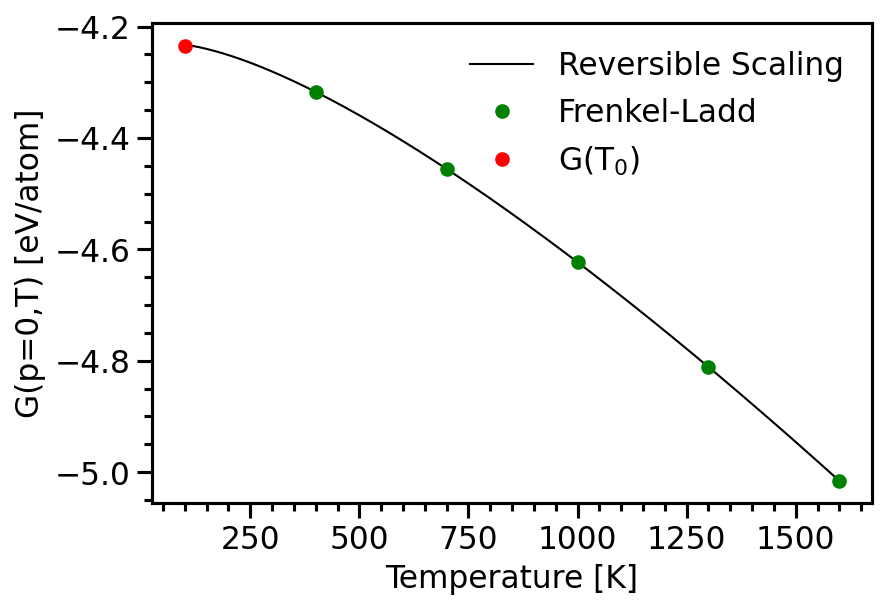

In [9]:
fl_params = [1000, 5000, 0.002]
fl_fcc = FrenkelLadd(pr=pr, potential=fe_potential, element='Fe', phase='fcc', struct_size=15, alat=3.55, temperature_lst=temperature_lst,
                     fl_input=fl_input, params=fl_params, restart=True)
fl_fcc.parameterize()
fl_fcc.run_jobs()
fl_fcc.compute_free_energy()
# fl.plot_results()

rs_params = [1000, 10000, 0.002, 100, 1600]
rs_fcc = ReversibleScaling(pr=pr, potential=fe_potential, params=rs_params, element='Fe', phase='fcc', struct_size=15, rs_input=rs_input,
                           fl_obj=fl_fcc, restart=True)
rs_fcc.run_job()
rs_fcc.compute_free_energy()
rs_fcc.plot_all()

## Fe Polymorphism from 100 K to 1600 K Including BCC and FCC Phases

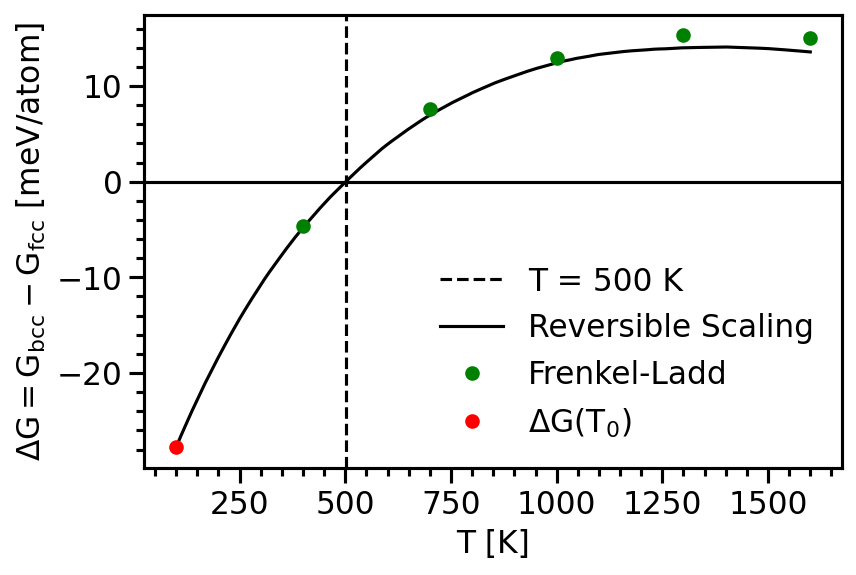

In [10]:
T_tr = rs_bcc.T_rs[np.argsort(rs_bcc.F_rs[rs_bcc.F_rs - rs_fcc.F_rs <= 0])][0]
plt.axvline(T_tr, color='k', linestyle='--', label=f'T = {int(T_tr)} K')
plt.plot(rs_bcc.T_rs, (rs_bcc.F_rs - rs_fcc.F_rs)*1000,'k', label='Reversible Scaling')
plt.plot(fl_bcc.T_fl[1:], (fl_bcc.F_fl[1:] - fl_fcc.F_fl[1:])*1000, 'go', label='Frenkel-Ladd')
plt.plot(fl_bcc.T_fl[0], (fl_bcc.F_fl[0] - fl_fcc.F_fl[0])*1000, 'ro', label='$\mathrm{\Delta G(T_{0})}$')
plt.axhline(0,color='k', linestyle='-')
plt.xlabel('T [K]')
plt.ylabel('$\mathrm{\Delta G = G_{bcc} - G_{fcc}}$ [meV/atom]')
plt.legend(frameon=False)

## pyiron job-table 

It is useful to look at the project job-table, as it has a lot of useful informations about the submitted jobs.

In [11]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1,finished,Fe6750,fl_parameterize_relax_bcc_T_100,/fl_parameterize_relax_bcc_T_100,/home/sam/,programs/ibrsam_git/FreeEnergyNoneqTI/reproduce_results/,2021-06-30 06:14:34.784234,2021-06-30 06:14:46.353651,11.0,pyiron@Lenovo#1,Lammps,0.1,None,None
1,2,finished,Fe6750,fl_parameterize_relax_bcc_T_400,/fl_parameterize_relax_bcc_T_400,/home/sam/,programs/ibrsam_git/FreeEnergyNoneqTI/reproduce_results/,2021-06-30 06:14:49.005037,2021-06-30 06:15:01.390647,12.0,pyiron@Lenovo#1,Lammps,0.1,None,None
2,3,finished,Fe6750,fl_parameterize_relax_bcc_T_700,/fl_parameterize_relax_bcc_T_700,/home/sam/,programs/ibrsam_git/FreeEnergyNoneqTI/reproduce_results/,2021-06-30 06:15:04.114830,2021-06-30 06:15:16.516955,12.0,pyiron@Lenovo#1,Lammps,0.1,None,None
3,4,finished,Fe6750,fl_parameterize_relax_bcc_T_1000,/fl_parameterize_relax_bcc_T_1000,/home/sam/,programs/ibrsam_git/FreeEnergyNoneqTI/reproduce_results/,2021-06-30 06:15:19.129336,2021-06-30 06:15:31.302686,12.0,pyiron@Lenovo#1,Lammps,0.1,None,None
4,5,finished,Fe6750,fl_parameterize_relax_bcc_T_1300,/fl_parameterize_relax_bcc_T_1300,/home/sam/,programs/ibrsam_git/FreeEnergyNoneqTI/reproduce_results/,2021-06-30 06:15:33.819625,2021-06-30 06:15:45.340034,11.0,pyiron@Lenovo#1,Lammps,0.1,None,None
5,6,finished,Fe6750,fl_parameterize_relax_bcc_T_1600,/fl_parameterize_relax_bcc_T_1600,/home/sam/,programs/ibrsam_git/FreeEnergyNoneqTI/reproduce_results/,2021-06-30 06:15:47.857764,2021-06-30 06:15:59.319379,11.0,pyiron@Lenovo#1,Lammps,0.1,None,None
6,7,finished,Fe6750,lmp_frenkel_ladd_bcc_T_100,/lmp_frenkel_ladd_bcc_T_100,/home/sam/,programs/ibrsam_git/FreeEnergyNoneqTI/reproduce_results/,2021-06-30 06:16:01.928499,2021-06-30 06:18:04.443586,122.0,pyiron@Lenovo#1,Lammps,0.1,None,None
7,8,finished,Fe6750,lmp_frenkel_ladd_bcc_T_400,/lmp_frenkel_ladd_bcc_T_400,/home/sam/,programs/ibrsam_git/FreeEnergyNoneqTI/reproduce_results/,2021-06-30 06:18:05.615711,2021-06-30 06:20:16.545648,130.0,pyiron@Lenovo#1,Lammps,0.1,None,None
8,9,finished,Fe6750,lmp_frenkel_ladd_bcc_T_700,/lmp_frenkel_ladd_bcc_T_700,/home/sam/,programs/ibrsam_git/FreeEnergyNoneqTI/reproduce_results/,2021-06-30 06:20:17.715152,2021-06-30 06:22:32.213172,134.0,pyiron@Lenovo#1,Lammps,0.1,None,None
9,10,finished,Fe6750,lmp_frenkel_ladd_bcc_T_1000,/lmp_frenkel_ladd_bcc_T_1000,/home/sam/,programs/ibrsam_git/FreeEnergyNoneqTI/reproduce_results/,2021-06-30 06:22:33.401971,2021-06-30 06:24:43.640765,130.0,pyiron@Lenovo#1,Lammps,0.1,None,None
